# Procedure #0 - Setting up the Jupyter Notebook

## Import Statements

In [1]:
from collections import deque
from dwave.cloud import Client
from dwave.samplers import SimulatedAnnealingSampler
from networkx import all_shortest_paths, has_path, shortest_path, draw_networkx, average_degree_connectivity
from numpy import loadtxt, savetxt
from operator import itemgetter
from shapely import overlaps, intersects 
from time import sleep
from typing import List

In [2]:
import copy 
import csv
import dimod
import geopandas as gpd
import gtfs_functions as gtfs
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pyperclip as pc
import random
import requests
import sys
import time 

## Importing credentials for D-Wave account

In [3]:
SAPI_HOME = "https://na-west-1.cloud.dwavesys.com/sapi/v2"
# Replace with your API token
SAPI_TOKEN = "DEV-66c376bfea2ebe6dc3a3c51d452baa586c67e109"     
r = requests.get(f"{SAPI_HOME}/problems/?max_results=3", headers={'X-Auth-Token': SAPI_TOKEN})
print(r.headers["Content-Type"])   

application/vnd.dwave.sapi.problems+json; version=2.1.0; charset=utf-8


## Global Variables

In [4]:
k = 5 # number of nodes each node should be connected to
infPlaceholder = 1000 # placeholder for infinity

## Global Helper Methods

### Formats matrix and copies it directly into clipboard

In [5]:
def print_matrix(A):
    pc.copy('\n\n'.join([''.join(['{:8}'.format(item) for item in row]) 
      for row in A]))

### Prints progress bar for big operations

In [6]:
def print_progress_bar(i, n):
    j = (i + 1) / n

    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.1)

# Procedure #1 - The QA UTRP Algorithm

## QA UTRP Algorithm Helper Methods

### Finds maximum theoretical cost of travel time and demand 

In [7]:
def get_max_cost(ttMatrix, demCostMatrix):
    V = len(ttMatrix)
    max_cost = 0
    
    # finds max cost
    for v in range(V):
        print_progress_bar(v, V)
        for w in range(V - v): # for every edge
            max_cost += (ttMatrix[v][w] * demCostMatrix[v][w]) / scaleFactor
    
    print()
    return max_cost

### Gets theta scaling factor to ensure constraints are always met

In [8]:
def get_theta(Q, lenCR):
    maxCost = -sys.maxsize
    
    for i in range(lenCR):
        for j in range(lenCR - i):        
            temp = abs(Q[i][j + i])
            if (temp > maxCost):
                maxCost = temp
      
    print(maxCost)
    return maxCost

### Shifts N by N matrix into a dictionary - need to pass dictionary into D-Wave solvers

In [9]:
def matrix_dict_shift(Q, lenCR, numRoutes):
    dictQ = {}
    length = len(Q)
    
    print("Shifting matrix into dictionary form!")
    
    # adding all intra-route costs
    for i in range(lenCR):
        print_progress_bar(i, lenCR)
        for j in range(lenCR - i):
            cost = Q[i][i + j]
            for route in range(numRoutes):
                x_index = route * lenCR + i
                y_index = route * lenCR + j + i
                dictQ[(x_index, y_index)] = cost
    
    print()    
    # adding all inter-route costs
    for i in range(lenCR):
        print_progress_bar(i, lenCR)
        for j in range(lenCR - i):
            cost = Q[i][lenCR + i + j]
            if (i == i + j):
                for index_1 in range(numRoutes - 1):
                    x_index = index_1 * lenCR + i
                    for index_2 in range(numRoutes - 1 - index_1):
                        y_index = (index_1 + index_2) * lenCR + lenCR + j + i
                        dictQ[(x_index, y_index)] = cost
            else:
                dx = i
                dy = i + j
                for index_1 in range(numRoutes - 1):
                    x_index = index_1 * lenCR
                    for index_2 in range(numRoutes - 1 - index_1):
                        y_index = (index_1 + index_2) * lenCR + lenCR
                        dictQ[(x_index + dx, y_index + dy)] = cost   
                        dictQ[(x_index + dy, y_index + dy)] = cost
    
    print()
    return dictQ

### Creates k-connected graph from a list of bus stops and travel time information

In [65]:
def create_node_graph(nodeIDList, ttMatrix):
    G = nx.Graph()
    G.add_nodes_from(nodeIDList)
    
    print("Creating connected node graph!")
    length = len(ttMatrix)
    for i in range(length):
        print_progress_bar(i, length)
        for j in range(length - i - 1):
            if (ttMatrix[i][i + j + 1] < infPlaceholder):
                #print(ttMatrix[i][j])
                G.add_edge(nodeIDList[i], nodeIDList[i + j + 1], 
                           travel_time=ttMatrix[i][i + j + 1])
    
    return G

In [10]:
# def create_node_graph(nodeIDList, ttMatrix):
#     G = nx.Graph()
#     G.add_nodes_from(nodeIDList)
    
#     length = len(ttMatrix)
#     for i in range(length):
#         knn = []
#         for l in range(k):
#             for j in range(length):
#                 if len(knn) < l + 1:
#                     knn.append(j)
#                 else:
#                     if (i != j) and (j not in knn) and (ttMatrix[i][knn[l]] > ttMatrix[i][j] and 
#                                                        ttMatrix[i][j] != infPlaceholder):
#                         knn[l] = j
#         for node in knn:
#             G.add_edge(nodeIDList[i], nodeIDList[node], travel_time=ttMatrix[i][node])
    
#     return G

## QA UTRP Objective Function Implementations

### Candidate route generator

In [61]:
def generate_routes(G, nodeIDList, tempMissingCRNodes, initial_generate):  
    index = 0
    missingCRNodes = copy.deepcopy(tempMissingCRNodes)
    
    candidateRoutes = []
    V = len(nodeIDList)
    length = V
    
    tempRoutes = []
    
    for i in range(V):
        for j in range(V - i - 1):
            if has_path(G, i, j):
                for path in nx.all_simple_paths(G, 
                                                source=i, 
                                                target=j, 
                                                cutoff=maxNodesPerRoute):
                    if path not in tempRoutes:
                        tempRoutes.append(path)
    
    candidateRoutes = tempRoutes
#     ##print(len(list(tempRoutes.keys())))
#     i = 0
    
#     if initial_generate:
#         for source in tempRoutes.keys():
#             print_progress_bar(i, length)
#             i += 1
#             for target in tempRoutes[source]:
#                 if source in missingCRNodes and len(tempRoutes[source][target]) >= minNodesPerRoute:
#                     candidateRoutes.append(tempRoutes[source][target])
#                     missingCRNodes.remove(source)
#                 elif len(tempRoutes[source][target]) >= minNodesPerRoute:
#                     candidateRoutes.append(tempRoutes[source][target])
#     else:
#         while len(missingCRNodes) > 0:
#             tempRoute = []
#             tempIndices = ()
#             numNodesFound = 0
#             i = 0
            
#             tempNodesFound = 0
            
#             for source in tempRoutes.keys():
#                 print_progress_bar(i, length)
#                 i += 1
#                 # for each path from v and w
#                 for target in tempRoutes[source]:
#                     route = tempRoutes[source][target]
#                     for node in missingCRNodes:
#                         if node in route:
#                             tempNodesFound += 1
                    
#                     if numNodesFound < tempNodesFound:
#                         numNodesFound = tempNodesFound
#                         tempIndices = (source, target)
#                         tempRoute = route
#                     tempNodesFound = 0
            
#             print()
#             # gets rid of all missing nodes that are "found"
#             for node in missingCRNodes:
#                     if node in tempRoute:
#                         missingCRNodes.remove(node)
            
#             candidateRoutes.append(tempRoute) # appends route to candidate routes
#             tempRoutes[tempIndices[0]][tempIndices[1]] = [] # makes sure route isn't duplicated
#             print("Number of missing nodes:", len(missingCRNodes))
        
#         for source in tempRoutes.keys():
#             print_progress_bar(i, length)
#             i += 1
#             for target in tempRoutes[source]:
#                 if len(tempRoutes[source][target]) >= minNodesPerRoute:
#                     candidateRoutes.append(tempRoutes[source][target])
    
#     print()
    return candidateRoutes

### Cost function implementation

In [12]:
def cost_function(Q, copyTTMatrix, demCostMatrix, numRoutes, candidateRoutes, nodeIDList, max_cost):
    ttMatrix = floyd_warshall(copy.deepcopy(copyTTMatrix))
    V = len(ttMatrix)
    length = len(Q)
    lenCR = len(candidateRoutes)
    
    # finds cost for each route
    for index in range(lenCR): # for each route
        print_progress_bar(index, lenCR)
        
        route = candidateRoutes[index]
        tot_cost = 0
        
        # finds total demand met (-cost) for route
        for i in range(len(route)):
            for j in range(len(route) - 1):
                tot_cost += int((ttMatrix[i][j] * demCostMatrix[i][j]) / scaleFactor)
                
        cost = max_cost - tot_cost
        
        # applies cost to all Q[i][j] that contain route
        for i in range(numRoutes): # for each bus
            tempIndex = i * lenCR + index
            for j in range(length - tempIndex): # for each horizontal index
                Q[tempIndex][tempIndex + j] += cost
            for j in range(tempIndex): # for each vertical index
                Q[j][tempIndex] += cost
    
    print()
    # accounts for any shared nodes 
    for index_1 in range(lenCR): # for each route
        print_progress_bar(index_1, lenCR)
        
        route_1 = candidateRoutes[index_1]
        for index_2 in range(lenCR): # for each route
            route_2 = candidateRoutes[index_2]
            
            combined_tot_cost = 0
            
            # checks if routes are not the same
            if not (route_1 == route_2):
                shared_nodes = []
                
                # if route_2 is smaller
                if len(route_1) > len(route_2):
                    for tempIndex in range(len(route_2)):
                        node = route_2[tempIndex]
                        if node in route_1:
                            shared_nodes.append(node)
                # if route_1 is smaller
                else:
                    for tempIndex in range(len(route_1)):
                        node = route_1[tempIndex]
                        if node in route_2:
                            shared_nodes.append(node)
                
                # for each shared node, correct the double addition of the cost
                shared_nodes_len = len(shared_nodes)
                for temp_node_index_1 in range(shared_nodes_len):
                    temp_node_1 = shared_nodes[temp_node_index_1]
                    crNodeIndex1 = nodeIDList.index(temp_node_1)
                    for temp_node_index_2 in range(shared_nodes_len - temp_node_index_1):
                        temp_node_2 = shared_nodes[temp_node_index_1 + temp_node_index_2]
                        
                        crNodeIndex2 = nodeIDList.index(temp_node_2)
                        
                        combined_tot_cost += int((ttMatrix[crNodeIndex1][crNodeIndex2] * 
                                               demCostMatrix[crNodeIndex1][crNodeIndex2]) / 
                                              scaleFactor)
                        
                # applies correction to matrix
                for i in range(numRoutes): # for each bus
                    Q[i * lenCR + index_1][i * lenCR + index_2] -= combined_tot_cost
            
    print()

### Constraint 1 implementation - Ensures there are only a certain number of routes that is specified by the user

In [13]:
def constraint_1(Q, theta, numRoutes, lenCR):
                    
    for i in range(numRoutes): # for each bus
        for j in range(lenCR): # for every route
            for k in range(lenCR - j):
                if (j == k + j):
                    Q[lenCR*i + j][lenCR*i + k + j] += -1 * theta * theta
                else:
                    Q[lenCR*i + j][lenCR*i + k + j] += 2 * theta * theta
                    
    print()

### Weight function - increases likelyhood of choosing a route set that visits all nodes at least once

In [14]:
def weight(Q, missingNodes, candidateRoutes, numRoutes, theta, nodeIDList):
    lenCR = len(candidateRoutes)
    length = len(Q)
    
    for i in range(length):
        for j in range(length - i):        
            for node in list(missingNodes.keys()):
                if ((node in candidateRoutes[i % lenCR]) or 
                        (node in candidateRoutes[(j + i) % lenCR])):
                    if i == j + i:
                        Q[i][j + i] *= (1 + missingNodes[node])
                    else:
                        Q[i][j + i] *= (1 - missingNodes[node])

In [15]:
# def weight(Q, missingNodes, candidateRoutes, numRoutes, theta, nodeIDList):
#     lenCR = len(candidateRoutes)
    
#     # gets min cost
#     minCost = sys.maxsize
    
#     for i in range(lenCR):
#         for j in range(lenCR - i):        
#             temp = Q[i][j + i]
#             if (temp < minCost):
#                 minCost = temp
    
#     length = len(Q)
    
#     # creates list of all missing nodes
#     missingNodesList = []
    
#     for node in list(missingNodes.keys()):
#         if missingNodes[node] > 0:
#             missingNodesList.append(nodeIDList[node])
    
#     numNodesFound = 0
#     tempRouteIndex = -1
    
#     while len(missingNodesList) > 0:
#         # gets route that "finds" most of the missing nodes and stores it
#         print('Getting route index')
#         for route_index in range(lenCR):
#             print_progress_bar(route_index, lenCR)
            
#             tempNodesFound = 0
#             route = candidateRoutes[route_index]
            
#             for node in missingNodesList:
#                 if node in route:
#                     tempNodesFound += 1
            
#             if (numNodesFound < tempNodesFound):
#                 numNodesFound = tempNodesFound
#                 tempRouteIndex = route_index
        
#         print()
#         # gets rid of all missing nodes that are "found"
#         route = candidateRoutes[tempRouteIndex]
#         print(route)
#         for node in missingNodesList:
#                 if node in route:
#                     missingNodesList.remove(node)
                
#         # weights chosen route
#         print('Applying cost!')
#         for i in range(numRoutes): # for each bus
#             print_progress_bar(i, numRoutes)
#             tempIndex = i * lenCR + tempRouteIndex
#             for j in range(length - tempIndex): # for each horizontal index
#                 Q[tempIndex][tempIndex + j] = 0
#             for j in range(tempIndex): # for each vertical index
#                 Q[j][tempIndex] = 0
            
#             Q[tempIndex][tempIndex] = minCost
        
#         print()
#         print('# missing nodes', len(missingNodesList))
#         # resets variables
#         numNodesFound = 0
#         tempRouteIndex = -1

## Complete QA UTRP Solver

### Combines the cost, contraint, and weight functions to create the Q matrix

In [16]:
def create_qubo_matrix(ttMatrix, demCostMatrix, numRoutes, missingNodes, nodeIDList, max_cost, candidateRoutes):
    
    lenCR = len(candidateRoutes)
    print('Num candidate routes:', lenCR) 
    
    Q = [ [0] * (lenCR  * 2) for i in range(lenCR  * 2)]
    Q = np.array(Q)
    
    print("Getting cost")
    theta = 1
    cost_function(Q, ttMatrix, demCostMatrix, 2, candidateRoutes, nodeIDList, max_cost)
    print("Adding constraints")
    #print(missingNodes)
    theta = get_theta(Q, lenCR)
    weight(Q, missingNodes, candidateRoutes, 2, theta, nodeIDList)
    constraint_1(Q, theta, 2, lenCR) # only numRoutes routes outputted
    
    print_matrix(Q)
    print("Finished matrix")
    
    return matrix_dict_shift(Q, lenCR, numRoutes)

### Plugs Q matrix into D-Waves quantum annealers and optimizes it

In [17]:
def utrp_solver(ttMatrix, demCostMatrix, numRoutes, missingNodes, nodeIDList, max_cost, candidateRoutes):
    
    print("Starting!")
    Q = create_qubo_matrix(ttMatrix, demCostMatrix, numRoutes, missingNodes, nodeIDList, max_cost, candidateRoutes)
    
    # classical SA sampler
    sampler = SimulatedAnnealingSampler()  
 
    #hybrid quantum-classical QA solver from D-Wave
    #from dwave.system import LeapHybridSampler
    #sampler = LeapHybridSampler()
    
    print("Converting QUBO to BQM")
    bqm = dimod.BQM.from_qubo(Q)
    
    print("Optimizing!")
    samples = sampler.sample(bqm, num_counts=20)
    
    print("Finished optimization!")
    
    return samples

### Runner code - Uses travel time and demand info to output a set of optimized routes

In [62]:
def route_solver(ttMatrix, demCostMatrix, numRoutes, nodeIDList):
    missingNodes = {}
    foundNodes = {}
    for node in range(len(nodeIDList)):
        missingNodes[node] = 0
        foundNodes[node] = 0
    
    
    count = 1
    allNodes = False
    cost = 2000
    
    print('Generating routes!')
    G = create_node_graph(nodeIDList, ttMatrix)
    draw_networkx(G, with_labels=False, node_size=3, width=0.05)
    candidateRoutes = generate_routes(G, nodeIDList, [], True)
    
    countCRNodes = -1
    missingCRNodes = []
    
    while (countCRNodes != 0 and count < 1):
        countCRNodes = 0
        for node in nodeIDList:
            if not any(node in sublist for sublist in candidateRoutes):
                countCRNodes += 1
                if node not in missingCRNodes:
                    missingCRNodes.append(node)
        
        print('Num missing candidate route nodes:', countCRNodes)
        
        if (countCRNodes != 0):
            candidateRoutes = generate_routes(G, nodeIDList, missingCRNodes, True)
    
    print('Number of candidate routes:', len(candidateRoutes))
    
    print('Getting max cost')
    max_cost = get_max_cost(ttMatrix, demCostMatrix)
    
    missingNodesList = []
    
    while (not allNodes):
        print("Run:", count)
        count += 1
    
        samples = utrp_solver(ttMatrix, demCostMatrix, numRoutes, missingNodes, nodeIDList, max_cost, candidateRoutes)

        sample = samples.samples()[0]
        V = len(candidateRoutes)
        solArray = []
        for k in list(sample.keys()):
            if (sample[k] == 1):
                solArray.append(candidateRoutes[k % V])
                for node in candidateRoutes[k % V]:
                    foundNodes[nodeIDList.index(node)] = 1

        index = 0
        numMissingNodes = 0
        containsAllNodes = True
        for isInRoute in list(foundNodes.values()):
            # if node is not in the route set
            if isInRoute == 0:
                numMissingNodes += 1
                missingNodes[index] += 1
                missingNodes[index] = round(missingNodes[index], 1)
                containsAllNodes = False

            index += 1
        print('Number of missing nodes:', numMissingNodes)
        
        print('Number of optimized routes:', len(solArray))
        
        # creates list of all missing nodes
        missingNodesList = []

        for node in list(missingNodes.keys()):
            if missingNodes[node] > 0:
                missingNodesList.append(node)

        candidateRoutes = generate_routes(G, nodeIDList, missingNodesList, False)
        
        if containsAllNodes:
#             sample = samples.samples()[0]

#             solArray = [] 

#             for k in list(sample.keys()):
#                 if (sample[k] == 1):
#                     solArray.append(candidateRoutes[k % V])
                    
            #if (att(solArray, ttMatrix, demCostMatrix) < 10.7) and (d0(solArray, demCostMatrix) > 0.90):
            
            allNodes = True
        else:
            for node in range(len(ttMatrix)):
                foundNodes[node] = 0
                
    return candidateRoutes, samples, missingNodesList

# Procedure 2 - Testing QA UTRP Solver on the Mandl's Swiss Road Network Benchmark

## Mandl Swiss benchmark helper methods 

### Floyd-Warshall algorithm for shortest travel distance

In [19]:
# creates shortest path matrix for every pair of vertices
def floyd_warshall(ttMatrix):
    V = len(ttMatrix[0]) # number of vertices 
    minDist = [ [None] * V for i in range(V)] # creates a V*V array 
    
    for i in range(V):
        for j in range(V):
            minDist[i][j] = ttMatrix[i][j]
        
    for k in range(V):
        for i in range(V):
            for j in range(V):
                if minDist[i][j] > minDist[i][k] + minDist[k][j]:
                    minDist[i][j] = minDist[i][k] + minDist[k][j]
                    
    return np.array(minDist)

### Creates list of all pairs of nodes and the number of transfers between them for a certain route set

In [20]:
def num_transfers(rSet, index, V):
    transferList = [[], [], [], []]
    binRSet = []
    
    ## d0 pairs
    for r in rSet:
        for i in range(len(r)):
            for j in range(len(r)-i-1):
                if (r[i], r[i+1+j]) not in transferList[0] and (r[i+1+j], r[i])  not in transferList[0]:
                    transferList[0].append((r[i], r[i+1+j]))
    
    ## d1 pairs 
    
    # creates binary version of route sets
    for r in rSet:
        tempBinRoute = [0] * V
        
        for vertex in r:
            tempBinRoute[vertex] = 1
            
        binRSet.append(tempBinRoute)
    
    for r1 in range(len(rSet) - 1):
        for tempRoute in range(len(rSet)-r1-1):
            r2 = tempRoute + r1 + 1
            isConnected = False
            # checks if route sets have one node in common
            # if they do, they are connected
            for vertex in range(V): 
                if (binRSet[r1][vertex] == 1 and binRSet[r2][vertex] == 1):
                    isConnected = True

            # checks all nodes in one route set 
            # with vertex in other route set that 
            # isn't in original route set
            if (isConnected):
                for vertex in range(V):
                    if (binRSet[r1][vertex] ^ binRSet[r2][vertex] == 1):
                        if (binRSet[r1][vertex] == 1):
                            for tempIndex in range(V):
                                if (tempIndex != vertex and binRSet[r2][tempIndex] == 1):
                                    if ((vertex, tempIndex) not in transferList[0] and (tempIndex, vertex) not in transferList[0] 
                                        and (vertex, tempIndex) not in transferList[1] and (tempIndex, vertex) not in transferList[1]):
                                        transferList[1].append((vertex, tempIndex))
                        else:
                            for tempIndex in range(V):
                                if (tempIndex != vertex and binRSet[r1][tempIndex] == 1):
                                    if ((vertex, tempIndex) not in transferList[0] and (tempIndex, vertex) not in transferList[0] 
                                        and (vertex, tempIndex) not in transferList[1] and (tempIndex, vertex) not in transferList[1]):
                                        transferList[1].append((vertex, tempIndex))
                                    
    
    return transferList[index]

## Methods to calculate performance parameters

### Average Travel Time (ATT)

In [21]:
def att(rSet, ttMatrix, demCostMatrix):
    V = len(ttMatrix[0])
    transitGraph = [ [sys.maxsize] * V for i in range(V)]
    
    # creates transit graph w/ travel times
    for i in range(V):
        transitGraph[i][i] = 0
    
    for r in rSet:
        for j in range(len(r)-1):
            tempV1 = r[j]
            tempV2 = r[j+1]
            transitGraph[tempV1][tempV2] = ttMatrix[tempV1][tempV2]      
            transitGraph[tempV2][tempV1] = ttMatrix[tempV2][tempV1]
            
    # finds min travel time for all pair of vertices  
    minDist = floyd_warshall(transitGraph)
    
    # finds average travel time - only uses upper triangular matrix
    ttt = 0
    totDemand = 0
    for i in range(V):
        for j in range(V-i):
            ttt += (demCostMatrix[i][j+i] * minDist[i][j+i]) 
            totDemand += demCostMatrix[i][j+i]
            
    return ttt/totDemand

### D0 - demand satisfied w/o transfers

In [22]:
def d0(rSet, demCostMatrix):
    V = len(demCostMatrix[0]) # number of vertices 
    d0Pairs = num_transfers(rSet, 0, V); 
    
    # calculates total demand
    totDemand = 0
    for i in range(V):
        for j in range(V-i):
            totDemand += demCostMatrix[i][j+i]
    
    # calculates d0 as demand nums
    totD0 = 0
    for pair in d0Pairs:
        totD0 += demCostMatrix[pair[0]][pair[1]]
                
    # returns d0 as a percentage   
    return totD0/totDemand 

### D1 - demand satisfied w/ 1 transfer

In [23]:
def d1(rSet, demCostMatrix):
    
    V = len(demCostMatrix[0]) # number of vertices 
    d0Pairs = num_transfers(rSet, 1, V); 
    
    # calculates total demand
    totDemand = 0
    for i in range(V):
        for j in range(V-i):
            totDemand += demCostMatrix[i][j+i]
        
    # calculates d1 as demand nums
    totD1 = 0
    for pair in d0Pairs:
        totD1 += demCostMatrix[pair[0]][pair[1]]
                
    # returns d1 as a percentage   
    return totD1/totDemand 

### D2 - demand satisfied w/ 2 transfers

In [24]:
def d2(rSet, ttMatrix, demCostMatrix):
    return 0.0

### Dun - demand not satisfied

In [25]:
def dun(rSet, ttMatrix, demCostMatrix):
    return 1.0 - d0(rSet, demCostMatrix) - d1(rSet, ttMatrix, demCostMatrix) - d2(rSet, ttMatrix, demCostMatrix)

## Importing Mandl Swiss Road Network Data

### Travel time data 

In [66]:
ttMatrix = []

with open("MandlTravelTimes.txt", 'r') as file:
    for line in file:
        elements = line.strip().split()
        for i in range(len(elements)):
            elem = elements[i]
            if (elem == "Inf"):
                elements[i] = infPlaceholder # placeholder for "biggest number"
            else:
                elements[i] = int(elem)
        
        if (len(elements) > 0):
            ttMatrix.append(elements)
            
ttMatrix = np.array(ttMatrix)

### Demand cost data

In [1]:
demCostMatrix = []

with open("MandlDemand.txt", 'r') as file:
    for line in file:
        elements = line.strip().split()
        for i in range(len(elements)):
            elements[i] = int(elements[i])
        
        if (len(elements) > 0):
            demCostMatrix.append(elements)

#demCostMatrix = np.array(demCostMatrix)

In [2]:
print(sum(sum(demCostMatrix,[])))

15570


## Getting results for optimized routes from QA UTRP solver and Mandl's Swiss Road Network

### Getting one set of optimized routes

In [68]:
# Variable List
numRoutes = 4
scaleFactor = 100 # scaling factor, ensures no overflow error working with real-world data
minNodesPerRoute = 3 # minimum number of nodes for each route
maxNodesPerRoute = 8 # maximum number of nodes for each route

Generating routes!
Creating connected node graph!
[====================] 100%Number of candidate routes: 1612
Getting max cost
[====================] 100%
Run: 1
Starting!
Num candidate routes: 1612
Getting cost
[                    ] 1%

KeyboardInterrupt: 

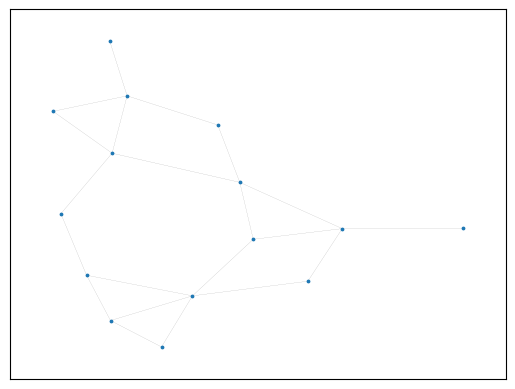

In [69]:
candidateRoutes, samples, _ = route_solver(ttMatrix, 
                                           demCostMatrix, 
                                           numRoutes,
                                          list([i for i in range(len(ttMatrix))]))

### Converting D-Wave optimized 'samples' into route set

In [ ]:
sample = samples.samples()[0]

V = len(candidateRoutes)
numRoutes = 4
solArray = [] 

for k in list(sample.keys()):
    if (sample[k] == 1):
        solArray.append(candidateRoutes[k % V])

### Running performance parameters on optimized route set

In [ ]:
quantumRouteSet = solArray
    
print('Optimized routes:', quantumRouteSet)

print('ATT:', att(quantumRouteSet, ttMatrix, demCostMatrix))
print('d0:', d0(quantumRouteSet, demCostMatrix))
print('d1:', d1(quantumRouteSet, demCostMatrix))

# Procedure #3 - Testing QA UTRP solver on bus routes in downtown Seattle

## Importing data about downtown Seattle

### Creating bounding box variables

In [32]:
pi = math.pi

dtSeaCoor = (47.61, -122.33)
r_earth = 6356700
distance = 1200

# need to make bounding box of possble lat-long points
lat_dx  = (distance / r_earth) * (180 / pi);
long_dy = (distance / r_earth) * (180 / pi) / math.cos(dtSeaCoor[0] * pi/180)

In [33]:
### Creating OSMnx graph of downtown Seattle

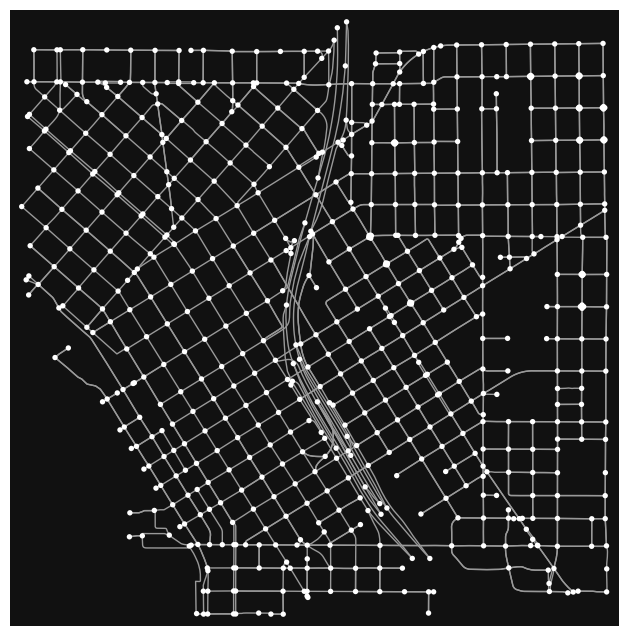

In [34]:
G = ox.graph_from_point(dtSeaCoor, dist=distance, network_type='drive')
fig, ax = ox.plot_graph(G)

### Importing all bus stops

In [35]:
nodeIDList = []
coorList = []
nodeCoorDict = {}

with open('stops.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            coor = (float(row[2]), float(row[3]))
            if ((dtSeaCoor[0] - lat_dx < coor[0] and dtSeaCoor[0] + lat_dx > coor[0]) and
                (dtSeaCoor[1] - long_dy < coor[1] and dtSeaCoor[1] + long_dy > coor[1])):
                nodeIDList.append(row[0])
                coorList.append(coor)
                nodeCoorDict[row[0]] = coor
                #print(coor)
        else:
            line_count += 1

### Creating travel time matrix - don't need to run if data is already saved!

In [36]:
numNodes = len(nodeIDList)
ttMatrix = [ [0] * numNodes for a in range(numNodes)]

G = ox.speed.add_edge_speeds(G) 
G = ox.add_edge_travel_times(G) # calculates travel times

print("Creating transit time matrix!")
for i in range(numNodes):
    print_progress_bar(i, numNodes)

    for j in range(numNodes - i):
        try:
            point = coorList[i]
            point2 = coorList[i + j]
            orig_node = ox.nearest_nodes(G, point[1], point[0])
            dest_node = ox.nearest_nodes(G, point2[1], point2[0])
            shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='travel_time') # finds the shortest path
            travel_time_list = ox.utils_graph.get_route_edge_attributes(G, shortest_route, attribute='travel_time')
            tot_time = round(sum(travel_time_list), 1) # total travel time (in seconds)
            ttMatrix[i][i + j] = tot_time
            ttMatrix[i + j][i] = tot_time
        except:
            ttMatrix[i][i + j] = infPlaceholder
            ttMatrix[i + j][i] = infPlaceholder
            pass
        
ttMatrix = np.array(ttMatrix)
# save to csv file
savetxt('downtownSeattleTravelTimeMatrix.csv', ttMatrix, delimiter=',')

Creating transit time matrix!
[=====               ] 28%

KeyboardInterrupt: 

### Adding Annual Average Weekday Traffic (AAWT) to graph attributes

In [ ]:
boundary_geojson = gpd.read_file('2018_Traffic_Flow_Counts.geojson')

def add_AAWDT(G, linestring, AAWDT):
    for edge in G.edges():
        if (('geometry' in G[edge[0]][edge[1]][0]) and 
            intersects(ox.utils_geo.round_geometry_coords(G[edge[0]][edge[1]][0]['geometry'], 5), (ox.utils_geo.round_geometry_coords(linestring, 5)))):
            
            if ('AAWDT' in G[edge[0]][edge[1]][0]):
                G[edge[0]][edge[1]][0]['AAWDT'] += AAWDT
            else:
                G[edge[0]][edge[1]][0]['AAWDT'] = AAWDT

print('Applying demand to graph attributes!')
for index, row in boundary_geojson.iterrows():
    print_progress_bar(index, 1906)
     
    street = row['geometry']
    tempAAWDT = row['AWDT_ROUNDED']
    if street.geom_type == 'LineString':
        add_AAWDT(G, street, tempAAWDT)
    else:
        numLines = len(street.geoms)
        for line in street.geoms:
            add_AAWDT(G, line, tempAAWDT/numLines)

### Creating demand cost matrix - don't need to run if data is already saved!

In [ ]:
numNodes = len(nodeIDList)
demCostMatrix = [ [0] * numNodes for a in range(numNodes)]
print("Creating demand cost matrix!")

for coor1 in range(len(coorList)):
    print_progress_bar(coor1, numNodes)

    for coor2 in range(len(coorList) - coor1):
        try:
            point = coorList[coor1]
            point2 = coorList[coor1 + coor2]
            orig_node = ox.nearest_nodes(G, point[1], point[0])# find the nearest node to the end location
            dest_node = ox.nearest_nodes(G, point2[1], point2[0])#  find the shortest path
            shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='travel_time')
            tot_AAWDT = 0
            if len(shortest_route) > 1:
                for index in range(len(shortest_route) - 1):
                    if 'AAWDT' in G[shortest_route[0]][shortest_route[1]][0]:
                        tot_AAWDT += G[shortest_route[0]][shortest_route[1]][0]['AAWDT']

                #print(G[shortest_route[0]][shortest_route[1]])
            demCostMatrix[coor1][coor1 + coor2] = int(tot_AAWDT)
            demCostMatrix[coor1 + coor2][coor1] = int(tot_AAWDT)
        except:
            demCostMatrix[coor1][coor1 + coor2] = 0
            demCostMatrix[coor1 + coor2][coor1] = 0
            pass
        
demCostMatrix = np.array(demCostMatrix)
# save to csv file
savetxt('downtownSeattleDemandCostMatrix.csv', demCostMatrix, delimiter=',')

### Loads in saved travel time and demand cost matrix information

In [ ]:
numNodes = len(nodeIDList)
ttMatrix = loadtxt('downtownSeattleTravelTimeMatrix.csv', delimiter=',')
demCostMatrix = loadtxt('downtownSeattleDemandCostMatrix.csv', delimiter=',')
print(ttMatrix)
print(demCostMatrix)

## Getting results for existing bus routes for downtown Seattle bus routes

### Getting routes from shapes.txt file in GTFS folder of downtown Seattle bus route information

In [ ]:
existing_routes = []

with open('shapes.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    current_shape_id = 0
    temp_route_coors = []
    count = 0
    
    for row in csv_reader:
        if line_count != 0:
            coor = (float(row[2]), float(row[3]))
            if ((dtSeaCoor[0] - lat_dx < coor[0] and dtSeaCoor[0] + lat_dx > coor[0]) and
                (dtSeaCoor[1] - long_dy < coor[1] and dtSeaCoor[1] + long_dy > coor[1])):
                
                if (current_shape_id == row[0]):
                    if (count % 15 == 0):
                        temp_route_coors.append(coor)
                else:
                    current_shape_id = row[0]
                    existing_routes.append(temp_route_coors)
                    temp_route_coors = []
                    count = 0

                count += 1
        else:
            line_count += 1
            
existing_routes.remove([])

### Plot all coordinate points of each trip segment

In [ ]:
fig, ax = ox.plot_graph_route(G, shortest_route, show=False, close=False)

for route in existing_routes:
    for coor in route:
        ax.scatter(coor[1], coor[0], c='red')

plt.show()

### Connects all trip shape points into connected segments

In [ ]:
print_routes_list = []
routes_len = []

for route_index in range(len(existing_routes)):
    print_progress_bar(route_index, len(existing_routes))
    
    temp_route_list = []
    route = existing_routes[route_index]
    count = 0
    for node_index in range(len(route) - 1):
        point = route[node_index]
        point2 = route[node_index + 1]
        orig_node = ox.nearest_nodes(G, point[1], point[0])
        dest_node = ox.nearest_nodes(G, point2[1], point2[0])
        
        try:
            shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')
            print_routes_list.append(shortest_route)
            count += 1
        except nx.NetworkXNoPath:
            pass
    routes_len.append(count)
    count = 0

print()

### Converts all connected trip segments into a list of bus stops 

In [ ]:
coorNodeList1 = []

for coor in coorList:
    coorNodeList1.append(ox.nearest_nodes(G, coor[1], coor[0]))

routeSetAsStops = []
    
for route in print_routes_list:
    tempRoute = []
    for node in route:
        if node in coorNodeList1:
            index = coorNodeList1.index(node)
            tempRoute.append(index)
    
    routeSetAsStops.append(tempRoute)

### Converts list of bus stop segments into bus routes defined by a list of bus stops

In [ ]:
formattedRoutes = []

count = 0
for length in routes_len:
    tempRoute = []
    for i in range(length):
        for stop in routeSetAsStops[count]:
            if len(tempRoute) > 0 and (stop not in tempRoute):
                tempRoute.append(stop)
            elif len(tempRoute) == 0:
                tempRoute.append(stop)
        if (tempRoute not in formattedRoutes):
            formattedRoutes.append(tempRoute)
        count += 1

print(formattedRoutes)

### Formats demand cost matrix to only include bus stops that existing bus routes meet

In [ ]:
demCostMatrix = loadtxt('downtownSeattleDemandCostMatrix.csv', delimiter=',')

missingNodesList = []

for stop in range(len(nodeIDList)):
    if not any(stop in sublist for sublist in formattedRoutes):
        missingNodesList.append(stop)
        
print(missingNodesList)
i = 0
for index in missingNodesList:
    print_progress_bar(i, len(missingNodesList))
    i += 1 
    
    for j in range(len(demCostMatrix)):
        demCostMatrix[index][j] = 0
        demCostMatrix[j][index] = 0

print()

### Gets downtown Seattle's existing bus route set statistics

In [ ]:
# need to convert from seconds to minutes for ATT
print(att(formattedRoutes, ttMatrix, demCostMatrix) / 60)

num_d0 = d0('ATT:', formattedRoutes, demCostMatrix)
print('d0:', num_d0)

num_d1 = d1(formattedRoutes, demCostMatrix)
print('d1:', num_d1)

print(1 - num_d0 - num_d1)

### Plots all existing bus routes into an OSMnx graph of downtown Seattle

In [ ]:
print_routes_list = []

for route_index in range(len(formattedRoutes)):
    temp_route_list = []
    route = formattedRoutes[route_index]
    for node_index in range(len(route) - 1):
        point = coorList[route[node_index]]
        point2 = coorList[route[node_index + 1]]
        orig_node = ox.nearest_nodes(G, point[1], point[0])
        dest_node = ox.nearest_nodes(G, point2[1], point2[0])
        try:
            shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')
            print_routes_list.append(shortest_route)
        except nx.NetworkXNoPath:
            pass

color_list = 'purple'
fig, ax = ox.plot_graph_routes(G, print_routes_list, route_colors=color_list)

## Getting results for optimized routes from QA UTRP solver for downtown Seattle bus routes

### Getting one set of optimized routes

In [ ]:
# Variable List
numRoutes = 20
scaleFactor = 1000000 # scaling factor, ensures no overflow error working with real-world data

In [ ]:

candidateRoutes, samples, missingNodesList = route_solver(ttMatrix, 
                                                          demCostMatrix, 
                                                          numRoutes, 
                                                          nodeIDList)

### Converting D-Wave optimized 'samples' into route set

In [ ]:
sample = samples.samples()[0]

V = len(candidateRoutes)
solArray = [] 

for k in list(sample.keys()):
    if (sample[k] == 1):
        solArray.append(candidateRoutes[k % V])

### Converting optimized bus stop route set into index route set

In [ ]:
quantumRouteSet = []

for route in solArray:
    tempRoute = []
    for node in route:
        tempRoute.append(nodeIDList.index(node))
    quantumRouteSet.append(tempRoute)
    
print(quantumRouteSet)

### Modifying demand cost matrix to only include nodes the optimized route set meets

In [ ]:
i = 0
for index in missingNodesList:
    print_progress_bar(i, len(missingNodesList))
    i += 1 
    
    for j in range(len(demCostMatrix)):
        demCostMatrix[index][j] = 0
        demCostMatrix[j][index] = 0

print()

### Running performance parameters on optimized route set

In [ ]:
# need to convert from seconds to minutes for ATT
print('ATT:', att(quantumRouteSet, ttMatrix, demCostMatrix) / 60)

num_d0 = d0(quantumRouteSet, demCostMatrix)
print('d0:', num_d0)

num_d1 = d1(quantumRouteSet, demCostMatrix)
print('d1:', num_d1)

### Plotting optimized route set on OSMnx graph of downtown Seattle

In [ ]:
print_routes_list = []

for route_index in range(len(quantumRouteSet)):
    temp_route_list = []
    route = quantumRouteSet[route_index]
    for node_index in range(len(route) - 1):
        point = coorList[route[node_index]]
        point2 = coorList[route[node_index + 1]]
        orig_node = ox.nearest_nodes(G, point[1], point[0])
        dest_node = ox.nearest_nodes(G, point2[1], point2[0])
        
        try:
            shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')
            print_routes_list.append(shortest_route)
        except nx.NetworkXNoPath:
            pass
        
color_list = 'blue'
fig, ax = ox.plot_graph_routes(G, print_routes_list, route_colors=color_list, show=False, close=False)

plt.show()